In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from dataloaders import data_setup, engine
from torch import nn
from torchvision import transforms
from torchinfo import summary


In [3]:
torch.cuda.empty_cache()

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

Before we can start to use **transfer learning**, we will set up the dataset into DataLoaders

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
path = "S:/galaxydata/"
data_path = Path(path)
image_path = data_path / "data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")


S:\galaxydata\data directory exists.


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders



In [7]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d64b4a5610>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

### Creating a transform for `torchvision.models` 



In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1 # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d65178fcd0>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

## Getting a pretrained model


Here we use the base Vision Transformer Architecture from the <i><b>An Image is Worth 16x16 Words</i></b> paper

In [12]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
model = torchvision.models.vit_b_16(weights = weights, progress = False).to(device)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Getting a summary of our model with `torchinfo.summary()`

We use torchinfo to learn more about the model we are using:
To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
input_size = (32, 3, 224, 224)
summary(model=model, 
        input_size= input_size, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000] 768        True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    True
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_

### Freezing the base model and changing the output layer to suit our needs



In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.encoder.parameters():
    param.requires_grad = False

In [15]:
# for name, layer in model.named_modules():
#     if isinstance(layer, torch.nn.Dropout):
#          layer.p = 0.1

In [16]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#Change output classes to Astronomy classes
weights.meta['categories'] = class_names

In [17]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size= input_size, # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 9]    768        Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBloc

Here, we see that <i>Trainable</i> is set to False except for the final layer of the model

In [18]:
import torchinfo 
torchinfo.summary(model, input_size= input_size)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 9]                   768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-7 

## Train model



In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [20]:
for param in model.encoder.parameters():
    print(param)

Parameter containing:
tensor([[[-0.0012,  0.0027,  0.0025,  ...,  0.0016, -0.0019,  0.0053],
         [-0.0487, -0.0015, -0.1504,  ..., -0.0016,  0.0126,  0.0022],
         [-0.0044,  0.0053,  0.0087,  ..., -0.0032,  0.0326,  0.0080],
         ...,
         [-0.0308, -0.0188,  0.0755,  ..., -0.0082,  0.0706,  0.0176],
         [ 0.0068, -0.0188,  0.0045,  ..., -0.0083,  0.0681, -0.0098],
         [-0.0024, -0.0208, -0.1070,  ..., -0.0044,  0.0237, -0.0077]]],
       device='cuda:0')
Parameter containing:
tensor([-2.3007e-03,  4.8165e-02,  3.3885e-02,  4.7173e-04, -7.6144e-03,
         2.0363e-01, -5.8110e-03,  9.2717e-04, -5.0614e-03, -8.2545e-02,
         6.8284e-03,  5.1160e-02,  8.9581e-03, -1.4882e-03,  2.1149e-01,
         5.3371e-03,  1.1182e-02, -8.9904e-03,  3.2124e-04,  1.9837e-01,
         7.0043e-03,  5.9202e-02, -2.8005e-03,  5.7390e-03, -4.9855e-03,
         2.0885e-01,  5.8071e-02,  3.8558e-03,  6.0382e-02, -2.8765e-03,
        -1.8556e-03, -7.6262e-03,  1.5109e-01,  3.81

Parameter containing:
tensor([ 2.5063e-02, -3.4328e-02, -6.7732e-02,  3.8165e-03,  4.7264e-05,
         7.1638e-02,  8.8757e-05, -7.9703e-05,  9.2615e-04,  6.7721e-03,
        -5.0352e-05,  5.3311e-02, -1.1003e-03, -4.2476e-06, -4.3712e-05,
         1.0795e-02, -1.8346e-01, -1.1116e-01, -9.9983e-05,  4.8414e-05,
         1.7994e-01,  8.1460e-03,  2.2802e-03,  3.0147e-05,  7.7081e-05,
         1.8314e-01,  1.0119e-02,  1.8374e-01, -1.1999e-02, -4.5076e-02,
         1.8395e-01, -1.8468e-01, -1.8264e-01,  1.1250e-02, -2.4906e-02,
        -1.8351e-01, -8.3727e-04, -2.6371e-04,  1.5900e-02, -7.4709e-03,
         5.1461e-03, -1.2529e-04,  7.8101e-02,  2.1469e-02,  3.4202e-02,
         2.8027e-03, -2.4340e-02,  7.8039e-03,  5.7863e-03,  1.3862e-04,
        -1.8390e-01,  1.3079e-04, -6.0619e-02, -2.4968e-04,  4.8810e-04,
         1.0386e-03,  1.6881e-02, -1.3369e-02, -2.7706e-02, -2.4377e-05,
         3.8473e-05, -8.5238e-05,  1.4197e-01,  1.0993e-03, -2.2752e-05,
        -4.6048e-02, -1.8481e

Parameter containing:
tensor([ 5.8531e-01,  5.6042e-01,  5.7700e-01,  5.7286e-01,  4.7355e-01,
         3.6679e-01, -8.0660e-03, -9.7311e-03,  6.2421e-01,  6.5355e-01,
         4.5536e-02,  4.3148e-01,  1.1270e-02,  7.0828e-02, -2.0289e-02,
         5.9426e-01, -2.9986e-02,  1.8655e-01, -2.5465e-02,  2.6466e-01,
         6.0600e-01,  5.9376e-01,  1.7951e-01,  2.5471e-03,  2.8959e-02,
         2.1284e-01,  5.8428e-01,  1.1315e-01,  5.3792e-01,  3.0926e-01,
         7.5402e-02,  1.4079e-01,  8.0088e-04,  5.6841e-01,  6.2674e-01,
         6.2123e-02,  6.3668e-01, -6.2770e-02,  6.3795e-01,  4.1007e-01,
         4.9899e-01,  1.0115e-01,  6.0011e-01,  6.3050e-01,  4.5710e-01,
         6.5501e-01,  4.2857e-01,  5.7497e-01,  5.7491e-01, -3.4987e-02,
         1.3565e-01,  7.7969e-03,  4.8407e-01,  2.4047e-01,  5.8741e-01,
         5.9816e-01,  5.8389e-01,  5.7971e-01,  5.9617e-01, -2.0586e-02,
         1.6220e-01,  2.3109e-01,  5.6403e-01,  5.8257e-01, -2.6501e-02,
         6.5106e-01,  2.0271e

Parameter containing:
tensor([-9.7196e-03,  1.7278e-02,  4.2356e-03, -2.0398e-02,  1.2476e-02,
        -7.8623e-03, -2.0132e-03,  2.4820e-03,  1.5210e-02, -8.1123e-03,
         8.6654e-03, -3.5187e-03, -1.0876e-02, -6.4007e-03, -3.0950e-04,
         6.4454e-03, -1.2115e-03,  1.8022e-02, -2.3117e-03,  8.8904e-03,
         1.1802e-02, -8.3015e-03,  5.0181e-03, -2.4211e-03,  3.0151e-03,
        -1.5499e-02, -8.0718e-03, -1.6621e-03, -1.5789e-02,  1.9596e-03,
        -1.0075e-02,  2.0991e-03,  3.9647e-03,  1.6244e-02, -8.7457e-03,
        -3.8016e-03,  1.6986e-02,  8.0345e-03,  1.7856e-02,  2.0181e-02,
         6.9073e-03, -7.5195e-03, -1.6284e-02, -1.3267e-02, -3.3232e-03,
        -1.9535e-02,  1.4629e-03,  1.7964e-02,  2.9171e-02, -1.6910e-02,
        -6.2298e-03,  1.2408e-03, -3.4969e-04,  5.8351e-03, -1.1570e-02,
        -1.8743e-02, -1.2753e-03, -7.9013e-03, -2.0609e-02, -1.5286e-03,
        -7.0911e-03, -4.0631e-03, -2.7556e-01, -9.3520e-03,  9.9947e-03,
        -1.4548e-02, -5.3736e

Parameter containing:
tensor([ 0.6269,  0.6593,  0.6321,  0.6006,  0.6298,  0.6317,  0.4495,  0.4775,
         0.6062,  0.6333,  0.5500,  0.6042,  0.6049,  0.5980,  0.4388,  0.6429,
         0.4370,  0.5522,  0.5914,  0.5934,  0.6316,  0.6024,  0.6182,  0.4374,
         0.5314,  0.6272,  0.6419,  0.6026,  0.4533,  0.2967,  0.5986,  0.6210,
         0.4590,  0.6352,  0.6066,  0.5778,  0.6116,  0.5679,  0.6556,  0.5996,
         0.6158,  0.6225,  0.6513,  0.6187,  0.4826,  0.6392,  0.6023,  0.6086,
         0.4685,  0.6271,  0.6267,  0.4422,  0.4270,  0.6154,  0.6649,  0.6253,
         0.6308,  0.6244,  0.5408,  0.4610,  0.6472,  0.6452,  0.1510,  0.6619,
         0.5274,  0.6039,  0.6173,  0.6619,  0.6099,  0.5737,  0.5139,  0.6209,
         0.6509,  0.6228,  0.6029,  0.6105,  0.6104,  0.6122,  0.6566,  0.4490,
         0.4431,  0.5460,  0.6620,  0.5167,  0.6132,  0.6146,  0.6242,  0.5972,
         0.3204,  0.6280,  0.6315,  0.6177,  0.4622,  0.6635,  0.6420,  0.3040,
         0.6403,  

In [21]:
# Set the random seeds
torch.manual_seed(50)
torch.cuda.manual_seed(50)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       patience=3,
                       delta=0.05,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {(end_time-start_time)/60:.3f} minutes")
print(f"[INFO] Total training time: {(end_time-start_time)/3600:.3f} hours")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4939 | train_acc: 0.4634 | test_loss: 1.2544 | test_acc: 0.5542 | min_test_loss: 1.2544 | 
Epoch: 2 | train_loss: 1.1315 | train_acc: 0.5983 | test_loss: 1.1194 | test_acc: 0.5806 | min_test_loss: 1.1194 | 
Epoch: 3 | train_loss: 1.0141 | train_acc: 0.6379 | test_loss: 0.9858 | test_acc: 0.6507 | min_test_loss: 0.9858 | 
Epoch: 4 | train_loss: 0.9472 | train_acc: 0.6653 | test_loss: 0.9614 | test_acc: 0.6558 | min_test_loss: 0.9614 | 
Epoch: 5 | train_loss: 0.9144 | train_acc: 0.6760 | test_loss: 0.9095 | test_acc: 0.6794 | min_test_loss: 0.9095 | 
Epoch: 6 | train_loss: 0.8569 | train_acc: 0.7004 | test_loss: 0.8800 | test_acc: 0.6938 | min_test_loss: 0.8800 | 
Epoch: 7 | train_loss: 0.8345 | train_acc: 0.7055 | test_loss: 0.9015 | test_acc: 0.6843 | min_test_loss: 0.8800 | 
Epoch: 8 | train_loss: 0.8057 | train_acc: 0.7168 | test_loss: 0.8771 | test_acc: 0.6852 | min_test_loss: 0.8771 | 
Epoch: 9 | train_loss: 0.7870 | train_acc: 0.7264 | test_loss: 0.8820 | 

## Evaluate model by plotting loss curves

We can plot the loss curves using the `plot_loss_curves` function from the `helper_functions.py`script 

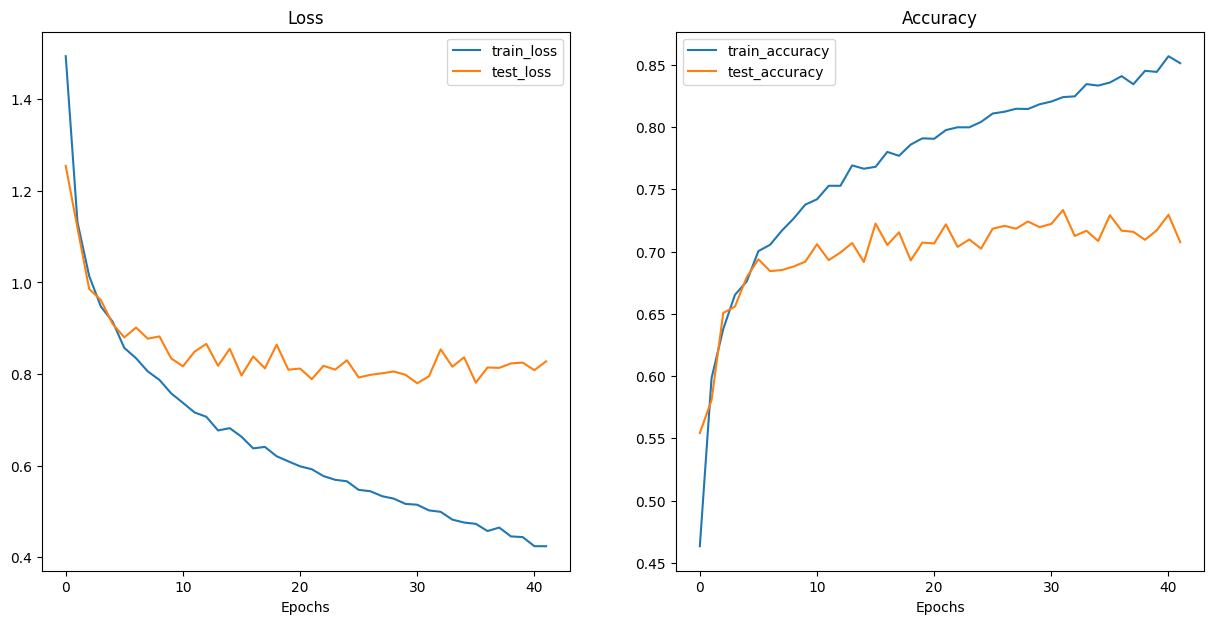

In [22]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [24]:
model_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/vit_90.pth"
engine.save_model(model, model_path)

results_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/results_90.npy"
engine.save_results(results, results_path)